# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(70, 6)


,title,price,year,link,brand,age
0,2013 subaru outback,7750,2013.0,https://charlottesville.craigslist.org/cto/d/c...,subaru,12.0
1,2014 audi a6,9500,2014.0,https://charlottesville.craigslist.org/cto/d/c...,audi,11.0
2,2019 chevy equinox ls,12500,2019.0,https://charlottesville.craigslist.org/cto/d/c...,chevy,6.0
3,2010 international 400 box truck,16500,2010.0,https://charlottesville.craigslist.org/cto/d/r...,missing,15.0
4,1955 chevrolet 210 2dr sedan,23500,1955.0,https://charlottesville.craigslist.org/cto/d/s...,chevrolet,70.0


With the data in and wrangled, we can now do some analysis:

count       70.000000
mean     11319.971429
std      13156.356557
min       1000.000000
25%       3500.000000
50%       7200.000000
75%      13625.000000
max      79999.000000
Name: price, dtype: float64


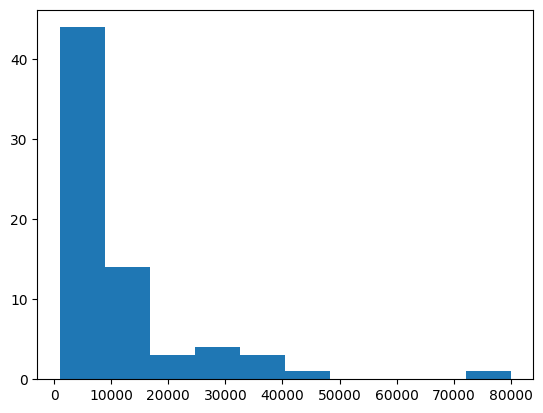

count    62.000000
mean     17.048387
std      12.783734
min       2.000000
25%      11.000000
50%      14.500000
75%      19.000000
max      70.000000
Name: age, dtype: float64


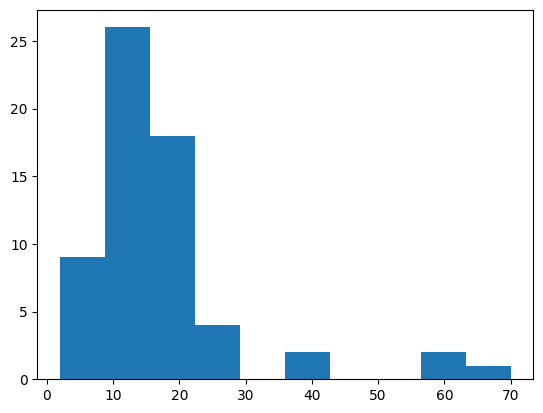

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
acura        1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
audi         2.0  28000.000000  26162.950904   9500.0  18750.00  28000.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.00  14230.0   
chevrolet    2.0  13500.000000  14142.135624   3500.0   8500.00  13500.0   
chevy        4.0  14749.750000   9350.106965   2999.0  10124.75  15500.0   
dodge        2.0  27000.000000  18384.776311  14000.0  20500.00  27000.0   
ford         6.0  12082.500000  12527.603023   1000.0   2100.00   7647.5   
honda        6.0   4391.666667   2017.031647   1000.0   3750.00   4700.0   
jeep         5.0   8990.000000   5182.952826   3250.0   5700.00   7500.0   
lexus        1.0   5000.000000           NaN   5000.0   5000.00   5000.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.00   1000.0   
missing     23.0  11601.695652  17561.745273   1000.0   2800.00   5000.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.00  23900.0   
subaru       3.0   5583.333333   3125.833222   2000.0   4500.00   7000.0   
toyota       8.0  10325.000000  10305.996867   3500.0   5900.00   7450.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.00   7500.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.00   4285.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi        37250.00  46500.0  
bmw         15365.00  16500.0  
chevrolet   18500.00  23500.0  
chevy       20125.00  25000.0  
dodge       33500.00  40000.0  
ford        21373.75  30000.0  
honda        5350.00   6950.0  
jeep        12500.00  16000.0  
lexus        5000.00   5000.0  
mazda        1000.00   1000.0  
missing     10000.00  79999.0  
porsche     23900.00  23900.0  
subaru       7375.00   7750.0  
toyota       8225.00  35500.0  
volkswagen   7500.00   7500.0  
volvo        4285.00   4285.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        1.0  18.000000        NaN  18.0  18.00  18.0  18.00  18.0
audi         2.0   6.500000   6.363961   2.0   4.25   6.5   8.75  11.0
bmw          3.0  13.000000   6.928203   9.0   9.00   9.0  15.00  21.0
chevrolet    1.0  70.000000        NaN  70.0  70.00  70.0  70.00  70.0
chevy        4.0  18.000000  14.899664   6.0   8.25  13.5  23.25  39.0
dodge        2.0  10.000000   1.414214   9.0   9.50  10.0  10.50  11.0
ford         6.0  13.000000   8.763561   4.0   5.00  12.5  20.75  23.0
honda        6.0  17.000000   4.242641  12.0  13.50  17.0  20.50  22.0
jeep         5.0  22.600000  11.436783  11.0  17.00  19.0  25.00  41.0
lexus        1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
mazda        1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
missing     17.0  17.941176  16.199809   5.0  10.00  13.0  17.00  62.0
porsche      1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
subaru       3.0  16.666667   8.962886  11.0  11.50  12.0  19.50  27.0
toyota       7.0  14.000000   6.557439   3.0  12.00  15.0  15.50  25.0
volkswagen   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0

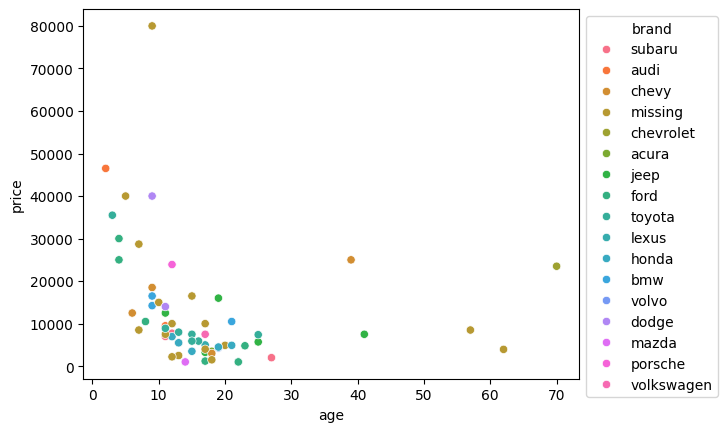

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.981703 -0.302244
log_age    -0.302244  0.423769
           log_price   log_age
log_price   1.000000 -0.472744
log_age    -0.472744  1.000000


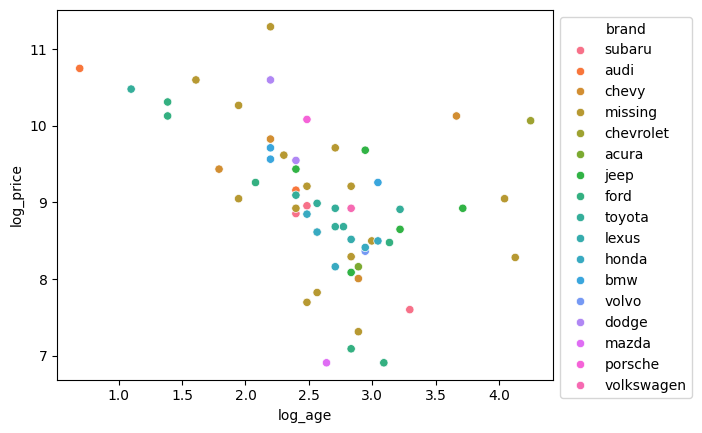

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

Fields want to gather

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

In [85]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cla?purveyor=owner#search=2~gallery~0'
raw = requests.get(url,headers=header)

In [86]:
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [87]:
import re

tops = ['shirt', 'blouse', 'tee', 't-shirt', 'tank', 'sweater', 'hoodie', 'pullover', 'top']
bottoms = ['pants', 'jeans', 'shorts', 'leggings','trousers', 'slacks']
jackets = ['jacket', 'coat', 'parka', 'vest', 'windbreaker', 'raincoat']
dresses = ['dress', 'gown', 'skirt', 'romper', 'jumpsuit']
shoes = ['shoes', 'boots', 'sneakers', 'sandals', 'heels', 'flats', 'trainers', 'slides', 'clogs']
bags = ['bag', 'purse', 'backpack', 'tote', 'handbag', 'satchel', 'duffle']
accessories = ['belt', 'hat', 'cap', 'beanie', 'scarf', 'gloves', 'sunglasses', 'watch', 'jewelry', 'bracelet', 'necklace', 'earrings', 'ring']

category_dictionary = {'tops': tops, 'bottoms': bottoms, 'jackets': jackets, 'dresses': dresses, 'shoes': shoes, 'bags': bags, 'accessories': accessories}


data = []
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    location_element = listings[k].find('div', class_ = 'location')
    if location_element:
        location = location_element.get_text().lower()
    else:
        location = 'missing'
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    if link.startswith('/'):
      link = "https://charlottesville.craigslist.org" + link

    tnorm = title.replace("tshirt", "t-shirt")
    found = False
    cat_label = 'other'
    item_word = 'unspecified'

    for cat, kw_list in category_dictionary.items():
        for w in kw_list:
            if re.search(rf"\b{re.escape(w)}\b", tnorm):
                cat_label = cat
                item_word = w
                found = True
                break
        if found:
            break

    data.append({'title':title, 'location':location, 'price':price,'category':cat_label, 'item': item_word if item_word else 'unspecified', 'link':link,})

In [88]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('./craigslist_cville_clothes.csv') # Save data in case of a disaster
df.head(20)

(130, 6)


,title,location,price,category,item,link
0,converse chuck taylor 70 new,\n charlottesville\n ...,50,other,unspecified,https://charlottesville.craigslist.org/clo/d/c...
1,"mens s/m clothing lot (shirts, flannels, hoodi...",\n ruckersville\n ...,60,other,unspecified,https://charlottesville.craigslist.org/clo/d/q...
2,mens boots,\n madison\n ...,100,shoes,boots,https://charlottesville.craigslist.org/clo/d/p...
3,mens work boots,missing,50,shoes,boots,https://charlottesville.craigslist.org/clo/d/b...
4,used asic women’s trainers,\n charlottesville\n ...,25,shoes,trainers,https://charlottesville.craigslist.org/clo/d/c...
5,vintage large pink puff sleeve satin dress/hea...,missing,50,dresses,dress,https://charlottesville.craigslist.org/clo/d/t...
6,straw hat narrow blue ribbon italy,missing,20,accessories,hat,https://charlottesville.craigslist.org/clo/d/t...
7,3 older type hats made china,missing,8,other,unspecified,https://charlottesville.craigslist.org/clo/d/t...
8,vintage frank olive for nieman marcus black hat,missing,50,accessories,hat,https://charlottesville.craigslist.org/clo/d/t...
9,vintage belmar cream black feather felt hat,missing,50,accessories,hat,https://charlottesville.craigslist.org/clo/d/t...


<Axes: xlabel='category', ylabel='price'>

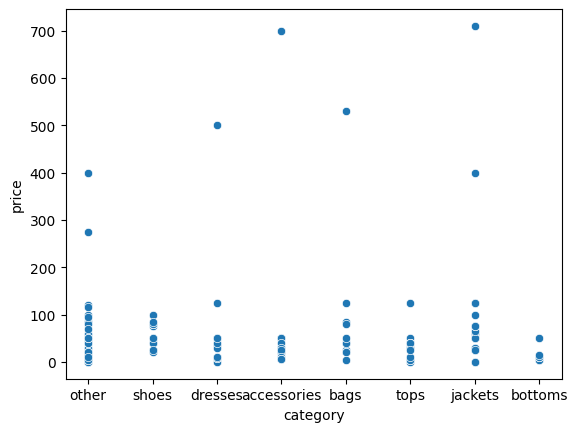

In [89]:
sns.scatterplot(data=df, x='category',y='price' )
#Note outliers. Next step remove to continue analysis

<Axes: xlabel='category', ylabel='price'>

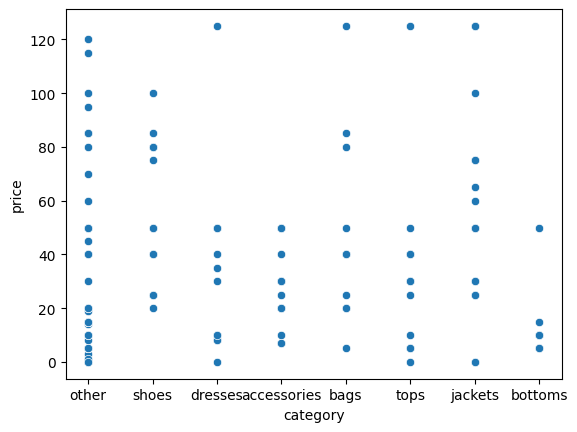

In [90]:
filter_df = df[df["price"]<= 200]
sns.scatterplot(data=filter_df, x='category',y='price' )

gender
mens      19
womens    11
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='price'>

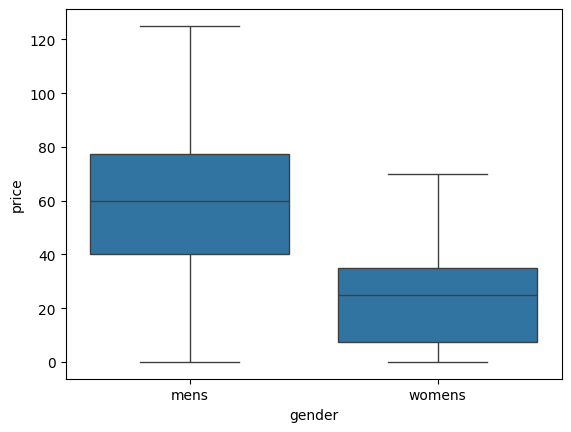

In [91]:
def spec_gender(title):
  title = title.lower()
  title = title.replace("’", "'").replace("‘", "'")

  if "women" in title:
    return 'womens'
  elif "men" in title:
    return 'mens'
  else:
    return None

df['gender'] = df['title'].apply(spec_gender)
df_filtered= df[df['gender'].notnull()]

print(df_filtered['gender'].value_counts())

sns.boxplot(data=df_filtered, x='gender', y='price')


In [92]:
#price by gender
df.loc[:,['price','gender']].groupby('gender').describe()

price                                                    
       count       mean        std  min   25%   50%   75%    max
gender                                                          
mens    19.0  58.736842  36.648241  0.0  40.0  60.0  77.5  125.0
womens  11.0  25.909091  24.167973  0.0   7.5  25.0  35.0   70.0

In [93]:
#price by category
df.loc[:,['price','category']].groupby('category').describe()

price                                                        
            count        mean         std   min   25%   50%    75%    max
category                                                                 
accessories  15.0   72.600000  174.184139   7.0  20.0  30.0  45.00  700.0
bags         11.0   92.727273  149.237456   5.0  22.5  40.0  82.50  530.0
bottoms       7.0   15.000000   15.811388   5.0   7.5  10.0  12.50   50.0
dresses      12.0   72.166667  138.885717   0.0   9.5  32.5  50.00  500.0
jackets      18.0  110.833333  173.859730   0.0  30.0  55.0  93.75  710.0
other        41.0   48.780488   75.926778   0.0   5.0  19.0  60.00  400.0
shoes        13.0   57.692308   26.818478  20.0  40.0  50.0  80.00  100.0
tops         13.0   33.076923   31.855040   0.0  10.0  30.0  40.00  125.0

In [104]:
# clean up the location types
df['location'] = df['location'].str.replace('\n', '')
df['location'] = df['location'].str.replace('                    ', '')
df['location'] = df['location'].str.replace('    ', '')
df['location'] = df['location'].str.replace(' in greene co.', '')
df['location'] = df['location'].str.replace('cville', 'charlottesville')
df['location'] = df['location'].str.replace('chville', 'charlottesville')
df['location'] = df['location'].str.replace('charlotesville', 'charlottesville')
df['location'] = df['location'].str.replace(', va.', '')
df['location'] = df['location'].str.replace('virginia', '')

for loc in df['location']:
  if 'charlottesville' in loc:
    df['location'] = df['location'].replace(loc, 'charlottesville')

df['location'].unique()


array(['charlottesville', 'ruckersville', 'madison', 'missing',
       'gordonsville', 'culpeper', 'lyndhurst', 'staunton', 'palmyra ',
       'stanardsville', 'palmyra', 'earlysville', 'zion crossroads',
       'keswick', 'amherst', 'waynesboro', 'aroda', 'crozet', 'pantops',
       'louisa'], dtype=object)

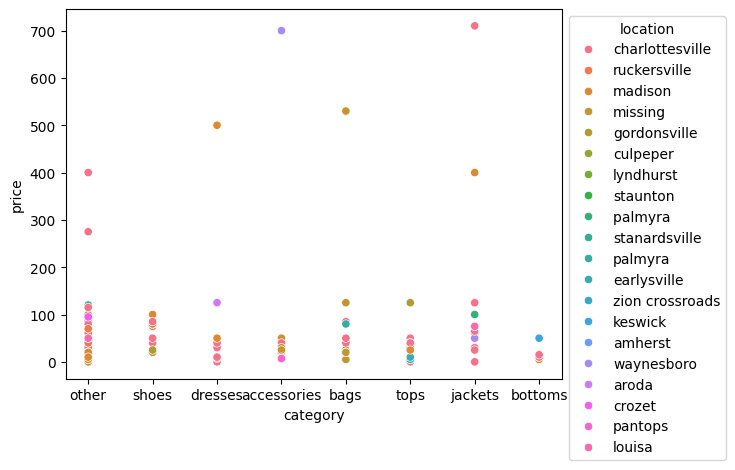

In [106]:
plot = sns.scatterplot(data=df, x='category', y='price',hue='location')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

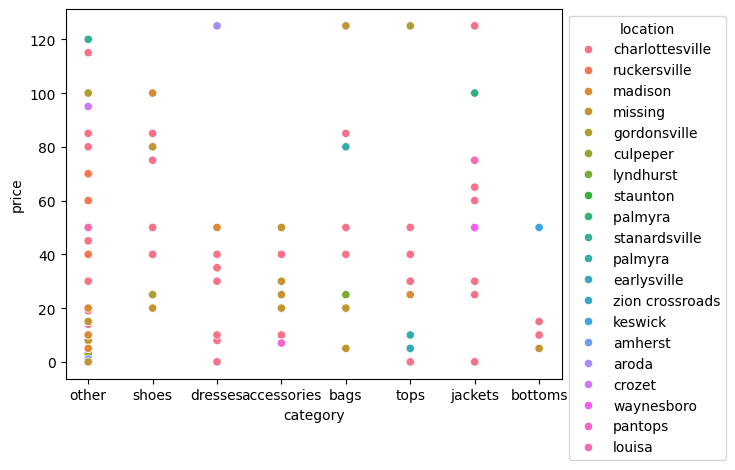

In [108]:
# remove outliers again
filter_df = df[df["price"]<= 200]
plot = sns.scatterplot(data=filter_df, x='category', y='price',hue='location')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

In [109]:
#price by location
df.loc[:,['price','location']].groupby('location').describe()

price                                                        \
                count        mean         std    min     25%    50%     75%   
location                                                                      
amherst           1.0    1.000000         NaN    1.0    1.00    1.0    1.00   
aroda             1.0  125.000000         NaN  125.0  125.00  125.0  125.00   
charlottesville  57.0   61.596491  108.640603    0.0   15.00   40.0   60.00   
crozet            1.0   95.000000         NaN   95.0   95.00   95.0   95.00   
culpeper          1.0    3.000000         NaN    3.0    3.00    3.0    3.00   
earlysville       4.0    7.000000    2.449490    5.0    5.00    6.5    8.50   
gordonsville      4.0   83.750000   42.500000   25.0   70.00   92.5  106.25   
keswick           1.0   50.000000         NaN   50.0   50.00   50.0   50.00   
louisa            3.0   66.666667   14.433757   50.0   62.50   75.0   75.00   
lyndhurst         1.0   25.000000         NaN   25.0   25.00   25.0   25.00   
madison          12.0  100.416667  166.671401    5.0   17.50   27.5   62.50   
missing          29.0   44.586207   97.135589    0.0    5.00   20.0   50.00   
palmyra           1.0   80.000000         NaN   80.0   80.00   80.0   80.00   
palmyra           1.0  100.000000         NaN  100.0  100.00  100.0  100.00   
pantops           2.0    7.000000    0.000000    7.0    7.00    7.0    7.00   
ruckersville      3.0   56.666667   15.275252   40.0   50.00   60.0   65.00   
stanardsville     2.0   67.500000   74.246212   15.0   41.25   67.5   93.75   
staunton          1.0   10.000000         NaN   10.0   10.00   10.0   10.00   
waynesboro        4.0  212.500000  325.000000   50.0   50.00   50.0  212.50   
zion crossroads   1.0   25.000000         NaN   25.0   25.00   25.0   25.00   

                        
                   max  
location                
amherst            1.0  
aroda            125.0  
charlottesville  710.0  
crozet            95.0  
culpeper           3.0  
earlysville       10.0  
gordonsville     125.0  
keswick           50.0  
louisa            75.0  
lyndhurst         25.0  
madison          500.0  
missing          530.0  
palmyra           80.0  
palmyra          100.0  
pantops            7.0  
ruckersville      70.0  
stanardsville    120.0  
staunton          10.0  
waynesboro       700.0  
zion crossroads   25.0